# **Обучение классификатора одежды**

Создание классификатора одежды на основе датасета FashionMNIST. 

Для этого разберём:

- Пайплайн обучения — все этапы, которые необходимо пройти для получения готовой обученной модели.
    
- Пайплайн инференса — процесс использования уже обученной модели для решения задач.

## Пайплайн обучения

Состоит из двух основных этапов.

- Этап 1. Подготовка данных. Состоит из:

    - Загрузки датасета (изображения + метки классов).
    - Деления датасета на обучающий и проверочный (тестовый или валидационный).
    - Предобработки датасета: нормализация, масштабирование, аугментация для обучающего датасета.

- Этап 2. Обучение. Состоит из:

    - Объявления архитектуры модели.
    - Выбора функции потерь и оптимизатора.
    - Написания функции для обучения и проверки.

В качестве датасета будет использоваться FashionMNIST. В нём 70000 примеров одежды, которую нужно разделить на 10 классов. Все изображения чёрно-белые и имеют размер 28×28px.

### Этап первый Подготовка данных

И обучающие, и проверочные изображения должны пройти через:

- масштабирование;

- приведение к формату torch.Tensor;
  
- нормализацию.

В нашем случае нормализацию можно провести любым способом — к примеру, через примерные среднее и стандартное отклонения (0.5).

Для обучающего датасета, помимо перечисленного, понадобится ещё аугментация.

In [2]:
from torchvision.transforms.v2 import (
    RandomRotation, 
    RandomPhotometricDistort,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    Compose )
from torchvision.transforms import (
    ToTensor,
    Normalize )
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from ml_dl_experiments import settings

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Предобработка и аугментация для обучающего датасета
train_transforms = Compose([
    RandomHorizontalFlip(p=0.3),
    RandomVerticalFlip(p=0.3),
    RandomRotation([-10, 10]),
    ToTensor(),
    Normalize((0.5),(0.5))
])

# Предобработка для теста
test_transforms = Compose([
    ToTensor(),
    Normalize((0.5),(0.5))
])

Загрузим датасет

In [5]:
from torchvision.datasets import FashionMNIST


train_dataset = FashionMNIST(
    root=settings.SOURCE_PATH + "datasets/",
    download=False,
    transform=train_transforms,
    train=True
)
test_dataset = FashionMNIST(
    root=settings.SOURCE_PATH + "datasets/",
    download=False,
    transform=test_transforms,
    train=False
)
print(f"Количество изображений в train: {len(train_dataset)}")
print(f"Количество изображений в test: {len(test_dataset)}")

Количество изображений в train: 60000
Количество изображений в test: 10000


Для упаковки данных в удобный для обучения вид используется DataLoader. Он удобен для больших датасетов.

In [6]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False 
)

In [12]:
# Названия классов из датасета
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

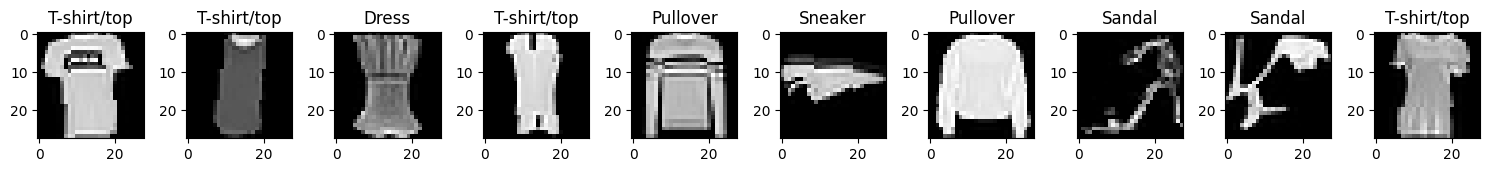

In [ ]:
fig = plt.figure(figsize=(15, 5))
for index in range(1, 11):
    image, label = train_dataset[index]
    plt.subplot(1, 10, index)
    plt.imshow(image[0], cmap="gray")
    plt.title(classes[label])

plt.tight_layout()
plt.show()

Классы соответствуют фото, аугментация не искажает изображения до неузнаваемости — а значит, можно приступать к обучению.

### **Этап второй - Обучение**

Этап состоит из следующих шагов:

- объявления модели, 

- выбора функции потерь и оптимизатора, 

- написания функций для цикла обучения.

Объявим модель:

In [7]:
class FashionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding="same")
        self.conv2 = nn.Conv2d(32, 64, 3, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # первый сверточный блок
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool(out)

        # второй сверточный блок
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.pool(out)
        
        # линейный блок
        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out

Обратите внимание, что в конце модели нет функции активации. Это связано с тем, что во время обучения Softmax встроен в функцию потерь для ускорения вычислений. А вот во время использования модели Softmax необязателен, так как для выбора итогового класса всё равно используется функция поиска максимума. Максимум выборки до и после применения Softmax сохраняется, поэтому нет необходимости добавлять его в архитектуру.

In [8]:
model = FashionClassifier()

Выберем оптимизатор и функцию потерь

In [9]:
lr: float = 0.01

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

Создадим функцию обучения одной эпохи:

In [11]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    for batch_index, data in enumerate(train_loader):
        # Извлечение батча
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Обнуление градиентов
        optimizer.zero_grad()
        # Прямое распространение
        outputs = model(inputs)
        # Подсчёт ошибки
        loss = criterion(outputs, labels)
        # Обратное распространение
        loss.backward()
        # Обновление весов
        optimizer.step()

        # Суммирование ошибки за последние 100 батчей
        running_loss += loss.item()
        if batch_index % 1000 == 999:
            last_loss = running_loss / 1000. # средняя ошибка за 1000 батчей
            print(f'Эпоха: {epoch_index}, батч: {batch_index}, ошибка: {round(last_loss, 3)}')
            running_loss = 0.
    
    return last_loss

Теперь общий процесс обучения:

In [13]:
import torch

EPOCHS = 15

best_vloss = 0.3
model.to(device)
for epoch in range(EPOCHS):
    print(f'Эпоха {epoch}')
    # Перевод модели в режим обучения 
    model.train()
    # Эпоха обучения
    avg_loss = train_one_epoch(epoch)
    # Перевод модели в режим оценки / валидации
    model.eval()
    running_vloss = 0.0

    # Валидация
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
    
    avg_vloss = running_vloss / (len(test_loader) + 1)

    # Сохранение лучше по качеству модели
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'models/fashion_classifier_epoch_{epoch}'
        torch.save(model.state_dict(), model_path)

    print(f'В конце эпохи ошибка train {avg_loss}, ошибка val {avg_vloss}') 

Эпоха 0
Эпоха: 0, батч: 999, ошибка: 0.413
Эпоха: 0, батч: 1999, ошибка: 0.407
Эпоха: 0, батч: 2999, ошибка: 0.425
В конце эпохи ошибка train 0.42465019949153066, ошибка val 0.4585829973220825
Эпоха 1
Эпоха: 1, батч: 999, ошибка: 0.414
Эпоха: 1, батч: 1999, ошибка: 0.414
Эпоха: 1, батч: 2999, ошибка: 0.401
В конце эпохи ошибка train 0.4007176179029047, ошибка val 0.4011855721473694
Эпоха 2
Эпоха: 2, батч: 999, ошибка: 0.402
Эпоха: 2, батч: 1999, ошибка: 0.396
Эпоха: 2, батч: 2999, ошибка: 0.407
В конце эпохи ошибка train 0.407372510664165, ошибка val 0.39046305418014526
Эпоха 3
Эпоха: 3, батч: 999, ошибка: 0.397
Эпоха: 3, батч: 1999, ошибка: 0.401
Эпоха: 3, батч: 2999, ошибка: 0.413
В конце эпохи ошибка train 0.41257473950833085, ошибка val 0.3815069794654846
Эпоха 4
Эпоха: 4, батч: 999, ошибка: 0.396
Эпоха: 4, батч: 1999, ошибка: 0.4
Эпоха: 4, батч: 2999, ошибка: 0.404
В конце эпохи ошибка train 0.40413038082793357, ошибка val 0.3761187493801117
Эпоха 5
Эпоха: 5, батч: 999, ошибка: 0.

In [8]:
model_path = f'models/fashion_classifier_epoch_30.pt'

In [ ]:
torch.save(model.state_dict(), model_path)

## Пайплайн инференса:

После того как модель обучена, нужно проверить качество её работы. Для этого нужно выполнить:

- Предсказание метки для всех примеров проверочного датасета.
  
- Вывод итоговых метрик.

Для загрузки обученной модели из файла нужно:

- Объявить её архитектуру, то есть создать новую модель с необученными весами.
  
- Загрузить в неё обученные веса.

Модель **не нужно дообучать**, поэтому другие параметры (состояние оптимизатора, скорость обучения) не нужны — понадобятся только веса. На это указывает параметр `weights_only=True`.

In [9]:
model = FashionClassifier()
model.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

Составим набор предсказаний на тестовой выборке

In [10]:
from sklearn.metrics import classification_report

labels_predicted = []
labels_true = []

model.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        labels_predicted.extend(predicted.numpy())
        labels_true.extend(labels.numpy())

print("Estimate successfully ended!")

Estimate successfully ended!


In [13]:
print(classification_report(labels_true, labels_predicted, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.80      0.86      0.83      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.79      0.88      0.84      1000
       Dress       0.84      0.91      0.88      1000
        Coat       0.82      0.80      0.81      1000
      Sandal       0.99      0.93      0.96      1000
       Shirt       0.74      0.60      0.66      1000
     Sneaker       0.92      0.97      0.95      1000
         Bag       0.97      0.95      0.96      1000
  Ankle boot       0.95      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

